In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

plt.style.use('seaborn')

#Sklearn imports
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
#Machine learning

In [2]:
dfRaw = pd.read_csv("data/train.csv")
dfRaw.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
dfRaw.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [4]:
dfRaw.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [5]:
dfWork = dfRaw.copy()
def splitCabin(cabin):
    var1 = var2 = var3 = 0
    if (type(cabin) == str) & (cabin != np.nan):
        var1 = cabin.split('/')[0]
        var2 = cabin.split('/')[1]
        var3 = cabin.split('/')[2]
    else:
        var1 = var2 = var3 = np.nan
    return var1, var2, var3

def splitPassengerId(pId):
    group = pId.split('_')[0]
    idInGroup = pId.split('_')[1]
    return group, idInGroup

def prepareForAnalysis(df, train = True):
    #Change the Cryosleep column
    df['CryoSleep'] = df['CryoSleep'].map({False:'No',True:'Yes'})
    #Same for Vip column
    df['VIP'] = df['VIP'].map({False:'No',True:'Yes'})
    #Applying a function in order to split the cabin column in 3
    df['deck'], df['num'], df['side'] = zip(*df['Cabin'].apply(splitCabin))
    dfWork['num'] = dfWork['num'].astype(int, errors = 'ignore')
    #Trying to treat the passenger Id variable
    df['PassengerGroup'], df['PassengerGroupId'] = zip(*df['PassengerId'].apply(splitPassengerId))
    dfWork['PassengerGroup'] = dfWork['PassengerGroup'].astype(int)
    dfWork['PassengerGroupId'] = dfWork['PassengerGroupId'].astype(int)

    df.drop(['Name','Cabin','PassengerId'], axis = 1, inplace = True)

    if train:
        df['Transported'] = df['Transported'].map({False:'No',True:'Yes'})
    return df


dfWork = prepareForAnalysis(dfWork,train=True)
dfWork
    


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side,PassengerGroup,PassengerGroupId
0,Europa,No,TRAPPIST-1e,39.0,No,0.0,0.0,0.0,0.0,0.0,No,B,0,P,1,1
1,Earth,No,TRAPPIST-1e,24.0,No,109.0,9.0,25.0,549.0,44.0,Yes,F,0,S,2,1
2,Europa,No,TRAPPIST-1e,58.0,Yes,43.0,3576.0,0.0,6715.0,49.0,No,A,0,S,3,1
3,Europa,No,TRAPPIST-1e,33.0,No,0.0,1283.0,371.0,3329.0,193.0,No,A,0,S,3,2
4,Earth,No,TRAPPIST-1e,16.0,No,303.0,70.0,151.0,565.0,2.0,Yes,F,1,S,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,No,55 Cancri e,41.0,Yes,0.0,6819.0,0.0,1643.0,74.0,No,A,98,P,9276,1
8689,Earth,Yes,PSO J318.5-22,18.0,No,0.0,0.0,0.0,0.0,0.0,No,G,1499,S,9278,1
8690,Earth,No,TRAPPIST-1e,26.0,No,0.0,0.0,1872.0,1.0,0.0,Yes,G,1500,S,9279,1
8691,Europa,No,55 Cancri e,32.0,No,0.0,1049.0,0.0,353.0,3235.0,No,E,608,S,9280,1


In [6]:
objectCols = dfWork.select_dtypes(include='object').columns
numCols = dfWork.select_dtypes(exclude='object').columns
objectCols, numCols

(Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported', 'deck',
        'num', 'side'],
       dtype='object'),
 Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
        'PassengerGroup', 'PassengerGroupId'],
       dtype='object'))

In [7]:
dfWork.dtypes

HomePlanet           object
CryoSleep            object
Destination          object
Age                 float64
VIP                  object
RoomService         float64
FoodCourt           float64
ShoppingMall        float64
Spa                 float64
VRDeck              float64
Transported          object
deck                 object
num                  object
side                 object
PassengerGroup        int64
PassengerGroupId      int64
dtype: object

In [8]:

dfWork[objectCols].nunique()

HomePlanet        3
CryoSleep         2
Destination       3
VIP               2
Transported       2
deck              8
num            1817
side              2
dtype: int64

In [9]:
dfWork[numCols].dtypes

Age                 float64
RoomService         float64
FoodCourt           float64
ShoppingMall        float64
Spa                 float64
VRDeck              float64
PassengerGroup        int64
PassengerGroupId      int64
dtype: object

In [10]:
dfWork[numCols].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,PassengerGroupId
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,4633.389624,1.517773
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,2671.028856,1.054241
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2319.000000,1.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4630.000000,1.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,6883.000000,2.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,9280.000000,8.000000


In [11]:
pd.set_option('display.max_rows', 500)
dfWork.groupby('Transported')[numCols].describe().T

Transported                       No           Yes
Age              count   4226.000000   4288.000000
                 mean      29.922858     27.748834
                 std       13.699262     15.151705
                 min        0.000000      0.000000
                 25%       21.000000     18.000000
                 50%       27.000000     26.000000
                 75%       38.000000     37.000000
                 max       79.000000     78.000000
RoomService      count   4217.000000   4295.000000
                 mean     389.266066     63.098021
                 std      875.638123    274.812497
                 min        0.000000      0.000000
                 25%        0.000000      0.000000
                 50%        1.000000      0.000000
                 75%      473.000000      0.000000
                 max    14327.000000   3992.000000
FoodCourt        count   4231.000000   4279.000000
                 mean     382.615930    532.691984
                 std     1200.115601   1931.306995
                 min        0.000000      0.000000
                 25%        0.000000      0.000000
                 50%        0.000000      0.000000
                 75%      179.000000      0.000000
                 max    16856.000000  29813.000000
ShoppingMall     count   4221.000000   4264.000000
                 mean     167.566217    179.829972
                 std      456.528126    722.026714
                 min        0.000000      0.000000
                 25%        0.000000      0.000000
                 50%        0.000000      0.000000
                 75%       95.000000      0.000000
                 max    10705.000000  23492.000000
Spa              count   4223.000000   4287.000000
                 mean     564.382666     61.675531
                 std     1551.356047    262.682871
                 min        0.000000      0.000000
                 25%        0.000000      0.000000
                 50%        4.000000      0.000000
                 75%      453.500000      0.000000
                 max    22408.000000   4103.000000
VRDeck           count   4225.000000   4280.000000
                 mean     543.629822     69.148131
                 std     1563.088368    291.658171
                 min        0.000000      0.000000
                 25%        0.000000      0.000000
                 50%        1.000000      0.000000
                 75%      388.000000      0.000000
                 max    24133.000000   5063.000000
PassengerGroup   count   4315.000000   4378.000000
                 mean    4575.572422   4690.374829
                 std     2730.673652   2609.968480
                 min        1.000000      2.000000
                 25%     2182.500000   2544.750000
                 50%     4462.000000   4781.000000
                 75%     6997.000000   6783.000000
                 max     9280.000000   9280.000000
PassengerGroupId count   4315.000000   4378.000000
                 mean       1.447277      1.587254
                 std        1.012984      1.089041
                 min        1.000000      1.000000
                 25%        1.000000      1.000000
                 50%        1.000000      1.000000
                 75%        1.000000      2.000000
                 max        8.000000      8.000000

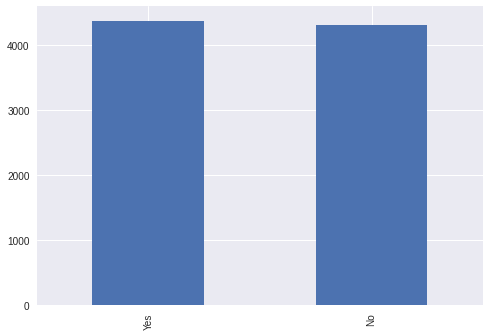

In [12]:
dfWork['Transported'].value_counts().plot.bar();

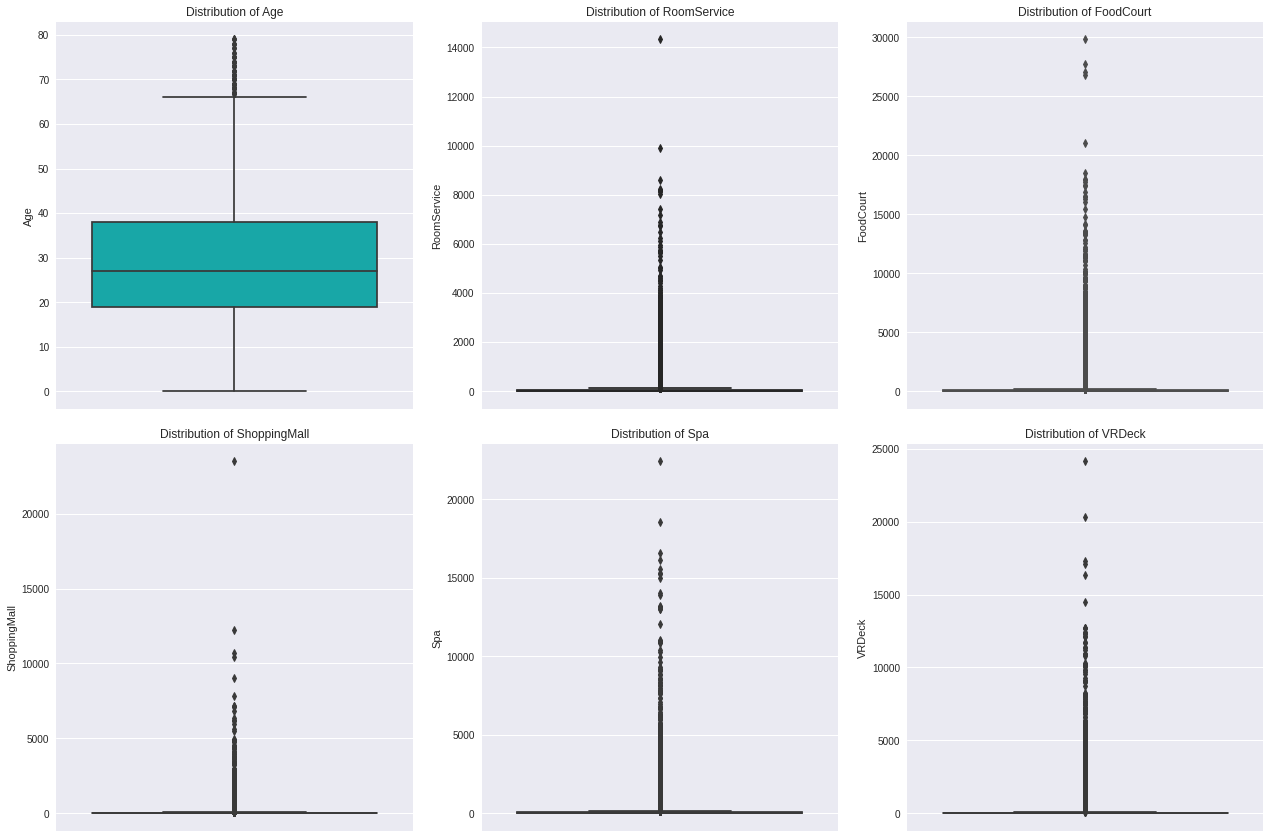

In [13]:
fig, ax = plt.subplots(nrows=2,ncols = 3, figsize = (18,12))


ax[0,0].set_title('Distribution of Age')
sns.boxplot(y = 'Age', data = dfWork, color = 'c', ax = ax[0,0])

ax[0,1].set_title('Distribution of RoomService')
sns.boxplot(y = 'RoomService', data = dfWork, color = 'g', ax = ax[0,1])

ax[0,2].set_title('Distribution of FoodCourt')
sns.boxplot(y = 'FoodCourt', data = dfWork, color = 'b', ax = ax[0,2])

ax[1,0].set_title('Distribution of ShoppingMall')
sns.boxplot(y = 'ShoppingMall', data = dfWork, color = 'm', ax = ax[1,0])

ax[1,1].set_title('Distribution of Spa')
sns.boxplot(y = 'Spa', data = dfWork, color = 'y', ax = ax[1,1])

ax[1,2].set_title('Distribution of VRDeck')
sns.boxplot(y = 'VRDeck', data = dfWork, color = 'y', ax = ax[1,2])

plt.tight_layout(pad = 2)
plt.show()

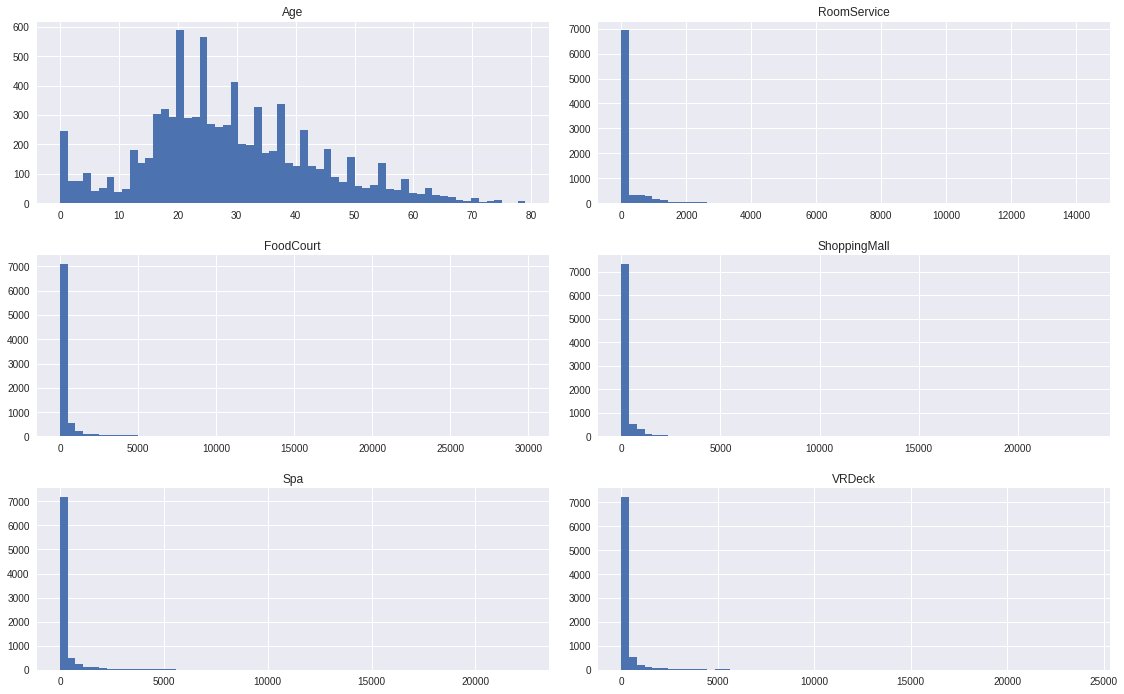

In [14]:
#plt.figure(figsize=(16,10))
dfWork[['Age','RoomService','FoodCourt', 'ShoppingMall','Spa','VRDeck']].hist(bins = 60, figsize=(16,10));
plt.tight_layout(pad = 2)
plt.show()

From the plot above we can easily see that appart from the variable Age all others have really a lot of outliers

The above plots show a lot of usefull information from the dataset, we can actually see:
1. If the home planet is Earth it is much more likely that the person will not be transported than those comming from Europa or Mars
2. CryoSleep seems to increase a lot in the chances that someone will transported
3. Destination = 55 Cancri e increases the chance of being transported
4. The number of VIP is actually quiet low but it decreases the chance of being transported

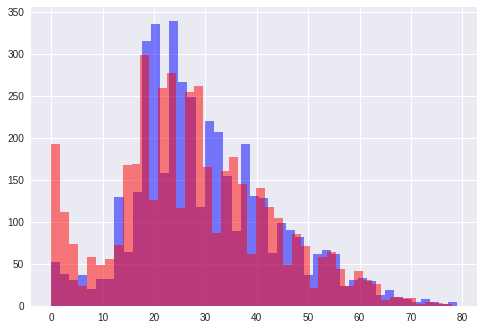

In [15]:
plt.hist(x =dfWork[dfWork['Transported'] == 'No']['Age'], bins = 45,color = 'b',alpha = 0.5, label = 'Not transported' );
plt.hist(x =dfWork[dfWork['Transported'] == 'Yes']['Age'], bins = 45,color = 'r',alpha = 0.5, label = 'Transported' );

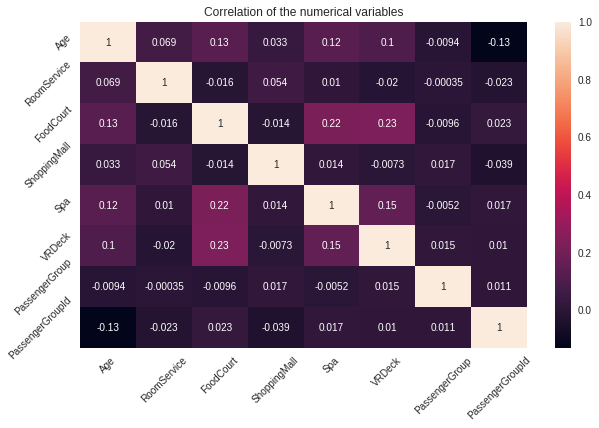

In [16]:
#Calculating the correlation of the numerical variables
corr = dfWork[numCols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True )
plt.yticks(rotation = 45)
plt.xticks(rotation = 45)
plt.title("Correlation of the numerical variables");

In [17]:
fig = px.scatter_matrix(dfWork,dimensions=['Age','RoomService','FoodCourt', 'ShoppingMall','Spa','VRDeck'], color = 'Transported', width = 1200,height=800)
fig.show()

### analyzing the Categorical variables

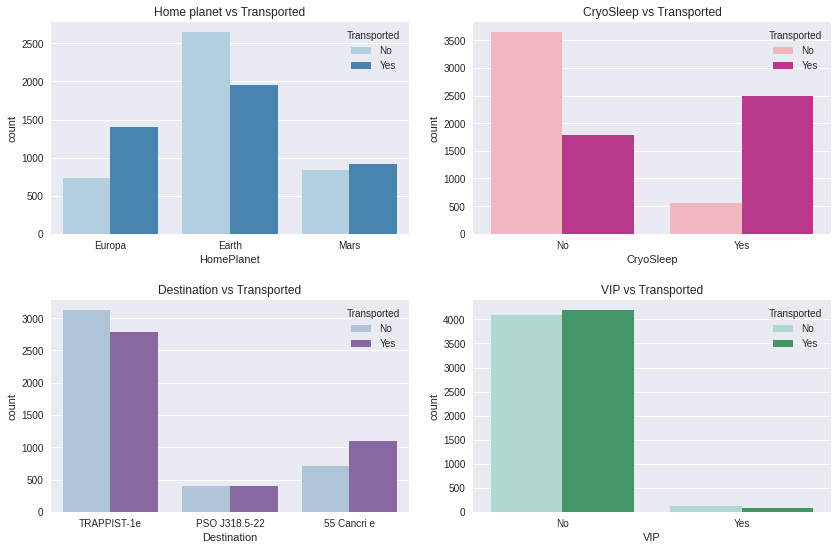

In [18]:
fig, ax = plt.subplots(nrows=2,ncols = 2, figsize = (12,8))

ax[0,0].set_title('Home planet vs Transported')
sns.countplot(x = 'HomePlanet', data = dfWork, hue = 'Transported', palette = 'Blues', ax = ax[0,0])
ax[0,1].set_title('CryoSleep vs Transported')
sns.countplot(x = 'CryoSleep', data = dfWork, hue = 'Transported', palette = 'RdPu', ax = ax[0,1])
ax[1,0].set_title('Destination vs Transported')
sns.countplot(x = 'Destination', data = dfWork, hue = 'Transported', palette = 'BuPu', ax = ax[1,0])
ax[1,1].set_title('VIP vs Transported')
sns.countplot(x = 'VIP', data = dfWork, hue = 'Transported', palette = 'BuGn', ax = ax[1,1])

plt.tight_layout(pad = 2)
plt.show()

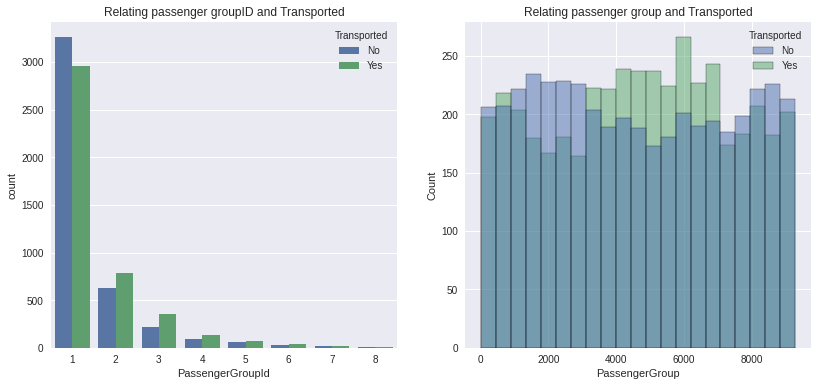

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
ax[0].set_title('Relating passenger groupID and Transported')
sns.countplot(x = 'PassengerGroupId', data = dfWork, hue = 'Transported', ax = ax[0]);
ax[1].set_title('Relating passenger group and Transported')
sns.histplot(data = dfWork, x = 'PassengerGroup', hue = 'Transported', ax = ax[1])
plt.tight_layout(pad = 3)
plt.show()

Passengers traveling alone have a slightly better chance to avoid beying transported

In [20]:
dfWork.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side,PassengerGroup,PassengerGroupId
0,Europa,No,TRAPPIST-1e,39.0,No,0.0,0.0,0.0,0.0,0.0,No,B,0,P,1,1
1,Earth,No,TRAPPIST-1e,24.0,No,109.0,9.0,25.0,549.0,44.0,Yes,F,0,S,2,1
2,Europa,No,TRAPPIST-1e,58.0,Yes,43.0,3576.0,0.0,6715.0,49.0,No,A,0,S,3,1
3,Europa,No,TRAPPIST-1e,33.0,No,0.0,1283.0,371.0,3329.0,193.0,No,A,0,S,3,2
4,Earth,No,TRAPPIST-1e,16.0,No,303.0,70.0,151.0,565.0,2.0,Yes,F,1,S,4,1


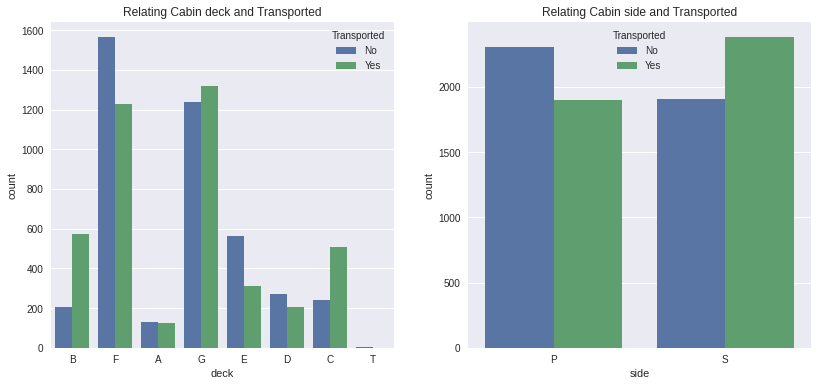

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
ax[0].set_title('Relating Cabin deck and Transported')
sns.countplot(x = 'deck', data = dfWork, hue = 'Transported', ax = ax[0]);
ax[1].set_title('Relating Cabin side and Transported')
sns.countplot(x = 'side', data = dfWork, hue = 'Transported', ax = ax[1]);


plt.tight_layout(pad = 3)
plt.show()

### Preparing the data for machine learning

In [42]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv('data/test.csv')
train = prepareForAnalysis(train, train = True)
test = prepareForAnalysis(test, train=False)


In [23]:
train.sample(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side,PassengerGroup,PassengerGroupId
2457,Earth,No,TRAPPIST-1e,22.0,No,NaN,0.0,137.0,671.0,NaN,No,G,419,S,2636,01
2355,Earth,No,PSO J318.5-22,23.0,No,0.0,9.0,292.0,35.0,349.0,Yes,E,152,P,2537,01
5969,Earth,Yes,TRAPPIST-1e,34.0,No,0.0,0.0,0.0,0.0,0.0,Yes,G,1026,S,6325,01
53,Europa,Yes,TRAPPIST-1e,38.0,No,0.0,0.0,0.0,0.0,0.0,Yes,A,1,S,0056,02
257,Europa,Yes,TRAPPIST-1e,14.0,No,0.0,0.0,0.0,0.0,0.0,Yes,E,16,P,0285,01


In [24]:
train.head(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side,PassengerGroup,PassengerGroupId
0,Europa,No,TRAPPIST-1e,39.0,No,0.0,0.0,0.0,0.0,0.0,No,B,0,P,0001,01
1,Earth,No,TRAPPIST-1e,24.0,No,109.0,9.0,25.0,549.0,44.0,Yes,F,0,S,0002,01
2,Europa,No,TRAPPIST-1e,58.0,Yes,43.0,3576.0,0.0,6715.0,49.0,No,A,0,S,0003,01
3,Europa,No,TRAPPIST-1e,33.0,No,0.0,1283.0,371.0,3329.0,193.0,No,A,0,S,0003,02
4,Earth,No,TRAPPIST-1e,16.0,No,303.0,70.0,151.0,565.0,2.0,Yes,F,1,S,0004,01
5,Earth,No,PSO J318.5-22,44.0,No,0.0,483.0,0.0,291.0,0.0,Yes,F,0,P,0005,01
6,Earth,No,TRAPPIST-1e,26.0,No,42.0,1539.0,3.0,0.0,0.0,Yes,F,2,S,0006,01
7,Earth,Yes,TRAPPIST-1e,28.0,No,0.0,0.0,0.0,0.0,NaN,Yes,G,0,S,0006,02
8,Earth,No,TRAPPIST-1e,35.0,No,0.0,785.0,17.0,216.0,0.0,Yes,F,3,S,0007,01
9,Europa,Yes,55 Cancri e,14.0,No,0.0,0.0,0.0,0.0,0.0,Yes,B,1,P,0008,01


In [25]:
test.sample(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,PassengerGroup,PassengerGroupId
4193,Mars,Yes,TRAPPIST-1e,33.0,No,0.0,0.0,0.0,0.0,0.0,F,1861,P,9091,01
899,NaN,No,55 Cancri e,35.0,No,557.0,0.0,0.0,393.0,0.0,G,304,P,1862,02
1626,Europa,No,TRAPPIST-1e,29.0,Yes,0.0,3285.0,0.0,0.0,8.0,A,32,P,3508,02
3849,NaN,No,TRAPPIST-1e,43.0,No,0.0,0.0,775.0,0.0,93.0,F,1617,S,8417,01
492,Europa,Yes,55 Cancri e,31.0,No,0.0,0.0,0.0,0.0,0.0,C,41,P,1061,01


In [43]:
catColsToImpute = ['HomePlanet','CryoSleep','Destination','VIP','deck','side']
catTransformer = make_column_transformer((SimpleImputer(strategy = 'most_frequent'),catColsToImpute))
catTransformer.fit(train)
train[catColsToImpute] = catTransformer.transform(train)
test[catColsToImpute] = catTransformer.transform(test)
catColsToEncode = ['HomePlanet','CryoSleep','Destination','deck','side']
catEncoder = make_column_transformer((OrdinalEncoder(),catColsToEncode))
catEncoder.fit(train)
train[catColsToEncode] = catEncoder.transform(train)
test[catColsToEncode] = catEncoder.transform(test)


numericColsToImpute = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

numTransformer = make_column_transformer((SimpleImputer(strategy='mean'),numericColsToImpute))
numTransformer.fit(train)
train[numericColsToImpute] = numTransformer.transform(train)
test[numericColsToImpute] = numTransformer.transform(test)

train['num'] = train['num'].fillna(method = 'ffill')
test['num'] = test['num'].fillna(method = 'ffill')

train['Transported'] = train['Transported'].map({'No':0,'Yes':1})
train['VIP'] = train['VIP'].map({'No':0,'Yes':1})
test['VIP'] = test['VIP'].map({'No':0,'Yes':1})

train['PassengerGroup'] = train['PassengerGroup'].astype(int)
train['PassengerGroupId'] = train['PassengerGroupId'].astype(int)
train['num'] = train['num'].astype(int)
test['PassengerGroup'] = test['PassengerGroup'].astype(int)
test['PassengerGroupId'] = test['PassengerGroupId'].astype(int)
test['num'] = test['num'].astype(int)


In [44]:
train.isna().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Transported         0
deck                0
num                 0
side                0
PassengerGroup      0
PassengerGroupId    0
dtype: int64

In [45]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side,PassengerGroup,PassengerGroupId
0,1.0,0.0,2.0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0,0,0.0,1,1
1,0.0,0.0,2.0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,5.0,0,1.0,2,1
2,1.0,0.0,2.0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0.0,0,1.0,3,1
3,1.0,0.0,2.0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0.0,0,1.0,3,2
4,0.0,0.0,2.0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,5.0,1,1.0,4,1


In [ ]:
train.dtypes

In [46]:
model = RandomForestClassifier(n_estimators=200, n_jobs=-1)

X = train.drop('Transported', axis = 1)
y = train['Transported']

cross_val_score(model,X = X, y = y, cv = 5, scoring = 'accuracy')


array([0.59286947, 0.73030477, 0.80506038, 0.8164557 , 0.74395857])

In [47]:
model = XGBClassifier(n_jobs = -1)

X = train.drop('Transported', axis = 1)
y = train['Transported']

cross_val_score(model,X = X, y = y, cv = 5, scoring = 'accuracy')

array([0.51696377, 0.67222542, 0.69695227, 0.69044879, 0.64614499])

In [ ]:
help(cross_val_score)

In [ ]:
#Features to create => Travelling alone

In [ ]:
help(sns.histplot)